In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd 
import scipy.linalg as la 
import graph_tool.all as gt 
import gln_v8 as gln
import sys
sys.path.insert(0, '/Users/glover.co/Documents/laszlo/NetDesign/scripts')
import net_design_refined as nd

### Idea 1. Make things match via edge using edge-O matrix. We denote as $E(O)$ where each row is an edge of a particle type and each column in the type of particle it can connect to. This will enforce the maximum degree constraint.

We consider first the hemoglobin example which has 3 proteins which we will denote A, B and C. In a whole they should form a four cycle where each node has one dangling edge.

In [4]:
O = np.array([[0,2,1],[2,0,1],[1,1,0]])
N = np.array([2,2,4])

In [7]:
E_O = np.array([[0,1,0],[0,1,0],[0,0,1],[1,0,0],[1,0,0],[0,0,1],[1,1,0]])

In [12]:
E_O.T@E_O

array([[3, 1, 0],
       [1, 3, 0],
       [0, 0, 2]])

Nodes in Universal Cover: [(0, ()), (1, (0,)), (2, (0,)), (6, (0,)), (7, (0,)), (8, (0,)), (3, (0, 1)), (4, (0, 1)), (6, (0, 1)), (7, (0, 1)), (3, (0, 2)), (6, (0, 2)), (7, (0, 2)), (9, (0, 2)), (1, (0, 6)), (2, (0, 6)), (7, (0, 6)), (8, (0, 6)), (1, (0, 7)), (2, (0, 7)), (6, (0, 7)), (8, (0, 7)), (9, (0, 7)), (3, (0, 8)), (6, (0, 8)), (7, (0, 8)), (2, (0, 1, 3)), (5, (0, 1, 3)), (8, (0, 1, 3)), (5, (0, 1, 4)), (9, (0, 1, 4)), (0, (0, 1, 6)), (2, (0, 1, 6)), (7, (0, 1, 6)), (8, (0, 1, 6)), (0, (0, 1, 7)), (2, (0, 1, 7)), (6, (0, 1, 7)), (8, (0, 1, 7)), (9, (0, 1, 7)), (1, (0, 2, 3)), (5, (0, 2, 3)), (8, (0, 2, 3)), (0, (0, 2, 6)), (1, (0, 2, 6)), (7, (0, 2, 6)), (8, (0, 2, 6)), (0, (0, 2, 7)), (1, (0, 2, 7)), (6, (0, 2, 7)), (8, (0, 2, 7)), (9, (0, 2, 7)), (4, (0, 2, 9)), (7, (0, 2, 9)), (0, (0, 6, 1)), (3, (0, 6, 1)), (4, (0, 6, 1)), (7, (0, 6, 1)), (0, (0, 6, 2)), (3, (0, 6, 2)), (7, (0, 6, 2)), (9, (0, 6, 2)), (0, (0, 6, 7)), (1, (0, 6, 7)), (2, (0, 6, 7)), (8, (0, 6, 7)), (9, (0, 6

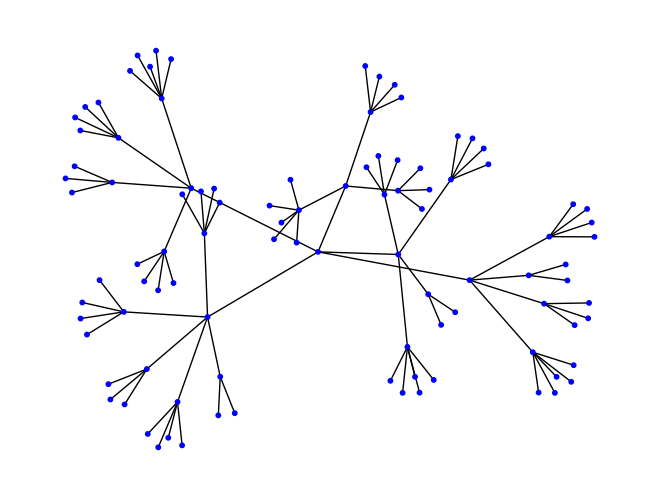

In [29]:
import networkx as nx

def construct_universal_cover(G, root, T):
    """
    Constructs a truncated universal cover of a graph G starting from a given root node,
    going out at most T steps.
    """
    cover = nx.Graph()
    queue = [(root, (), 0)]  # (current node, path history, depth)
    visited = {}
    
    while queue:
        node, path, depth = queue.pop(0)
        node_label = (node, path)  # Unique identifier for this node in the cover
        
        if node_label in visited or depth > T:
            continue
        visited[node_label] = True
        cover.add_node(node_label)
        
        for neighbor in G.neighbors(node):
            if path and neighbor == path[-1]:  # Avoid immediate backtracking
                continue
            new_path = path + (node,)
            neighbor_label = (neighbor, new_path)
            cover.add_edge(node_label, neighbor_label)
            queue.append((neighbor, new_path, depth + 1))
    
    return cover

# Example Usage
def example(G,T=2):
    root = 0
    # T = 5  # Maximum depth
    universal_cover = construct_universal_cover(G, root, T)
    print("Nodes in Universal Cover:", universal_cover.nodes)
    print("Edges in Universal Cover:", universal_cover.edges)
    
    # Visualizing the universal cover
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(universal_cover)
    colors = ['red' if node[0] == 12 else 'blue' for node in universal_cover.nodes]
    nx.draw(universal_cover, pos, with_labels=False, node_size=10, node_color=colors)
    plt.show()

G = nx.Graph()
G = nx.fast_gnp_random_graph(10,.5)
# G.add_edge(0,5)
example(G)


In [23]:
# Make a function that 

In [31]:
def particle_min(x):
    if len(x) >4:
        return len(x)
    elif len(x) == 4:
        return 2
    elif len(x) == 3:
        return 1
    else:
        return None
    
def upper_bound(G):
    net = {
        'nodes': {
            'labels': list(G.nodes),
            'positions': [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]]  # Dummy positions
        },
        'links': {}
    }

    # Add edges to the 'links' dictionary
    for edge in G.edges:
        edge_key = tuple([edge[0], edge[1]])
        net['links'][edge_key] = {
            'end_points': list(edge),
            'points': [[0, 0, 0], [1, 1, 1]],  # Dummy points
            'radius': 0.1  # Dummy radius
        }

    # Create the adjacency list
    adj_list = {node: list(G.neighbors(node)) for node in G.nodes}

    # Use the simplify_v8 class to find base loops
    simplifier = gln.simplify_v8(adj_list, net)
    simplifier.find_base_loops(num_source=1)  # num_source is the number of sources to start from

    # The base loops are stored in simplifier.base_loop
    base_loops = simplifier.base_loop
    
    # Get cycles
    cycles = [base_loops[b]['loop'] for b in base_loops.keys()]
    return cycles
    # # Get the lengths of the cycles
    # particle_nums = max([particle_min(cycle) for cycle in cycles])
    # return particle_nums

list(nx.chordless_cycles(G))

[[1, 0, 5, 4, 3, 2], [1, 0, 6, 2], [5, 0, 6, 4], [3, 2, 6, 4]]

In [21]:
class NetDesign:
    """
    
    """

19

In [ ]:
gt_G = gt.price_network(10,3)

In [41]:
G = nx.cycle_graph(4)
X = np.array([[1,0],[0,1],[1,0],[0,1]])
O = np.array([[0,2],[2,0]])

In [42]:
subgraph_test = nd.NetDesign(G,X,O)

In [51]:
G.add_nodes_from?

Signature: G.add_nodes_from(nodes_for_adding, **attr)
Docstring:
Add multiple nodes.

Parameters
----------
nodes_for_adding : iterable container
    A container of nodes (list, dict, set, etc.).
    OR
    A container of (node, attribute dict) tuples.
    Node attributes are updated using the attribute dict.
attr : keyword arguments, optional (default= no attributes)
    Update attributes for all nodes in nodes.
    Node attributes specified in nodes as a tuple take
    precedence over attributes specified via keyword arguments.

See Also
--------
add_node

Notes
-----
When adding nodes from an iterator over the graph you are changing,
a `RuntimeError` can be raised with message:
`RuntimeError: dictionary changed size during iteration`. This
happens when the graph's underlying dictionary is modified during
iteration. To avoid this error, evaluate the iterator into a separate
object, e.g. by using `list(iterator_of_nodes)`, and pass this
object to `G.add_nodes_from`.

Examples
--------

In [77]:
G = nx.cycle_graph(4)
H = nx.path_graph(3)

In [78]:
nx.set_node_attributes(G,{i:j for i,j in enumerate(X.argmax(axis=1))},'node_type')
nx.set_node_attributes(H,{i:j for i,j in enumerate(X.argmax(axis=1))},'node_type')

In [83]:
nx.weisfeiler_lehman_subgraph_hashes(G,iterations=4,node_attr='node_type')

{0: ['b94b177629f33f1740e92af7c505e673',
  '53411f632934ab7b19b3d5bbe9e1a5ef',
  'ccaa890e877beeb8183b611709c1f8f6',
  '1422dc520c83186d3427e35f94458163'],
 1: ['4b342ec70bc16941629e78f30e99d8f0',
  '5c750abababa1049a85ebb7f1d4bae8a',
  '4948f6946a069cd94783e128ba6576b2',
  '7f4c95ca93099a43e580491c7d33e798'],
 2: ['b94b177629f33f1740e92af7c505e673',
  '53411f632934ab7b19b3d5bbe9e1a5ef',
  'ccaa890e877beeb8183b611709c1f8f6',
  '1422dc520c83186d3427e35f94458163'],
 3: ['4b342ec70bc16941629e78f30e99d8f0',
  '5c750abababa1049a85ebb7f1d4bae8a',
  '4948f6946a069cd94783e128ba6576b2',
  '7f4c95ca93099a43e580491c7d33e798']}

In [80]:
nx.weisfeiler_lehman_subgraph_hashes(H,node_attr='node_type')

{0: ['59ee42e6c3d5df2f5e882533b849ee71',
  'e2a14f3414e302a442374eaaa4d91592',
  'daf79cb29322594647d44c1690fd1143'],
 1: ['4b342ec70bc16941629e78f30e99d8f0',
  'e6e2565b68d7ef66357ceff4303851b5',
  '3bb2464d280b769c25c89a2c7996543a'],
 2: ['59ee42e6c3d5df2f5e882533b849ee71',
  'e2a14f3414e302a442374eaaa4d91592',
  'daf79cb29322594647d44c1690fd1143']}

In [90]:
G = nx.Graph()
G.add_edges_from([[0,1],[1,2],[2,0],[0,3],[0,4],[0,5],[5,6]])

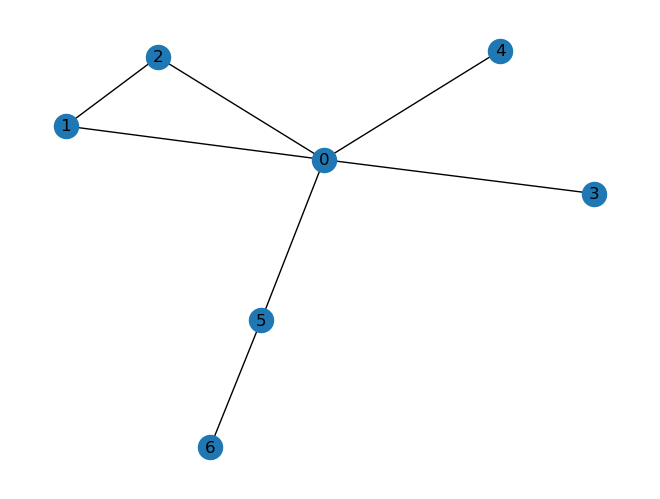

In [91]:
nx.draw(G,with_labels=True)

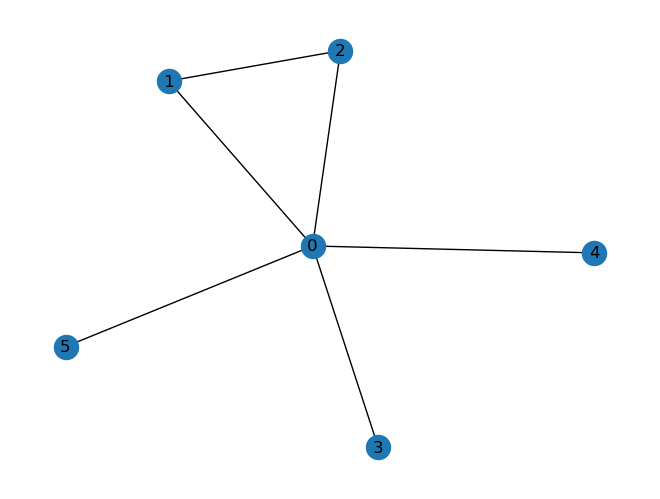

In [92]:
nx.draw(nx.ego_graph(G,0,radius=1),with_labels=True)